# Guided Project #10 - Answering Business Questions using SQL
By [Luis Munguia](http://www.linkedin.com/in/luis-munguia) and [Dataquest](http://www.dataquest.io)

In this guided project, I'll work with data from a ficticious company's database. The database has 11 tables and are related to a "music marketplace type service". 

My objetive is to follow the Python SQLite workflow to explore, analyze, and visualize data from this database.

The database schema is displayed below.

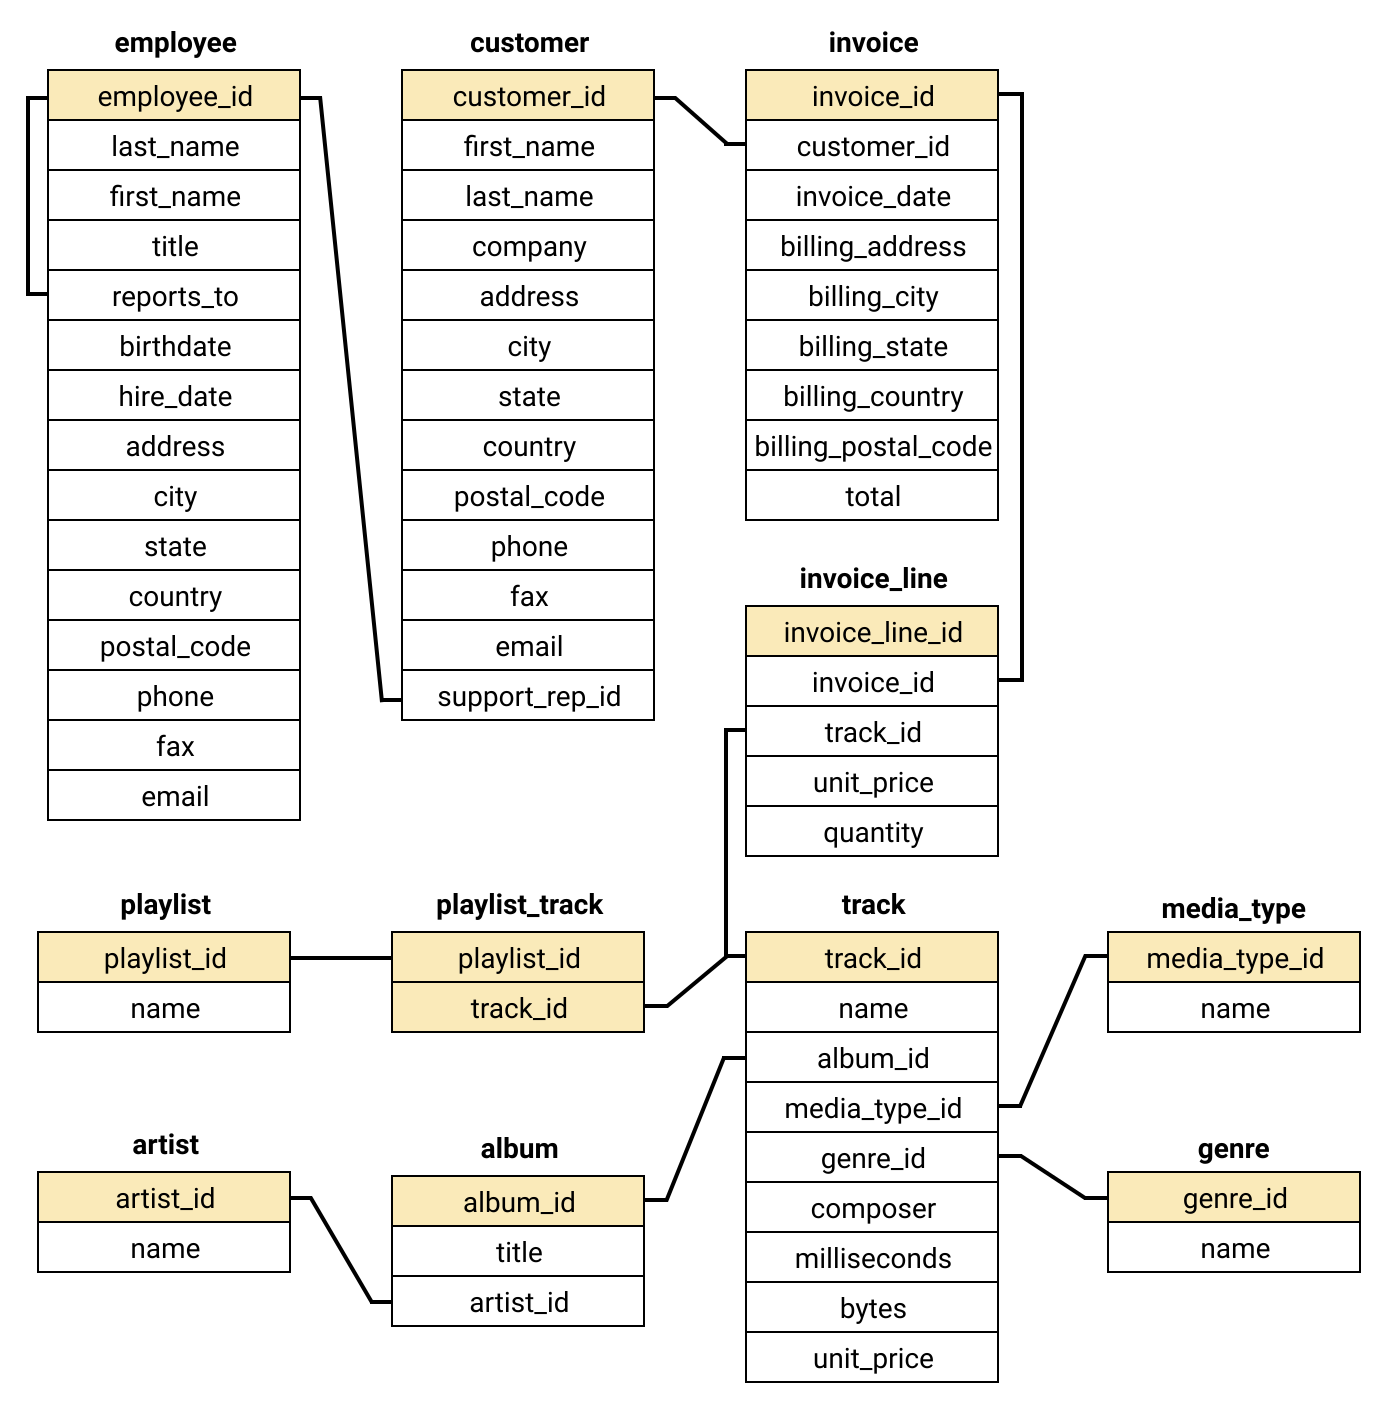

In [1]:
from IPython.display import SVG
SVG(url='https://s3.amazonaws.com/dq-content/191/chinook-schema.svg')

## 1.- Library and Jupyter setup.
Import `sqlite3`, `pandas` and `matplotlib` modules, call magic commands and create functions `run_query()`, `run_command()` and `show_tables()`.

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)

def show_tables():
    query = """SELECT name, type 
                    FROM sqlite_master 
                    WHERE type IN ('table','view');
                    """
    return run_query(query)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 2.- Selecting Albums to Purchase.
Chinook record store has signed a deal with a new record label that has 4 albums it doesn't carry. I can only choose 3, so I'll check which are the best selling genres to decide.

In [4]:
command1 = """CREATE VIEW usa_total_tracks AS
                SELECT il.* 
                FROM invoice AS i
                INNER JOIN invoice_line AS il ON il.invoice_id = i.invoice_id
                WHERE i.billing_country = "USA";
                """
run_command(command1)

OperationalError: table usa_total_tracks already exists

In [5]:
query1 = """SELECT 
            g.name AS Genre, COUNT(g.name) AS Total,
            1.0*COUNT(g.name)/(SELECT COUNT(*) FROM usa_total_tracks) AS "%"
            FROM usa_total_tracks AS utt
            INNER JOIN track AS t ON t.track_id = utt.track_id
            INNER JOIN genre AS g ON g.genre_id = t.genre_id
            GROUP BY 1
            ORDER BY 2 DESC
            LIMIT 10;
            """

run_query(query1)

,Genre,Total,%
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


According to my analysis, the new album's genre ranks are:
* PUNK is number 2
* BLUES is number 5 
* HIP-HOP is number 7
* POP number 8

So Red Tone, Slim Jim Bites and Regal are in! But first let's plot the genres to better visualize the gap.

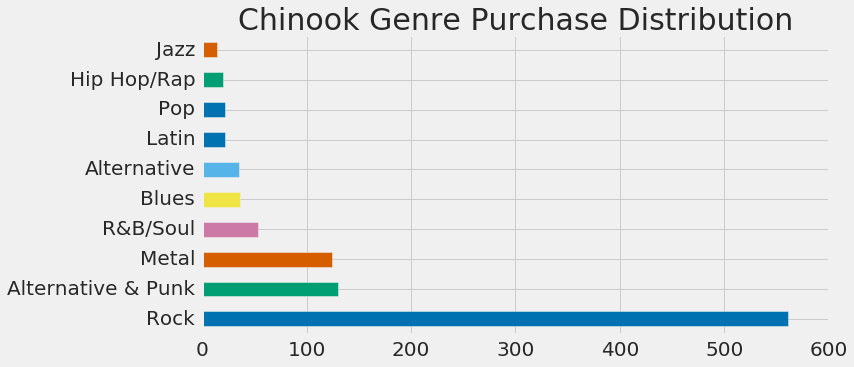

In [6]:
import matplotlib.style as style

style.use('fivethirtyeight')  #A style with better data ink.
sns.set_palette("colorblind") #A palette for colorblind people like me.

genres = run_query(query1)
genres.set_index("Genre",drop=True,inplace=True)
genres["Total"].plot.barh(figsize=(10,5),fontsize = 20)
plt.ylabel('')
plt.title("Chinook Genre Purchase Distribution",fontsize=30)

It seems that any rock album would do better by a extremely large margin. Sadly there was no rock album in the provided list.

## 3.- Analyzing Employee Sales Performance.

Chinook store assigns each customer to a sales support agent. Analyze each employee's perfomance to see how they rank to each other.

In [7]:
query2 = """SELECT
            e.first_name || " " || e.last_name AS Name,
            e.title,
            SUM(i.total) AS "Sales Total",
            e.birthdate,
            e.hire_date
            FROM invoice AS i
            INNER JOIN customer AS c ON i.customer_id = c.customer_id
            INNER JOIN employee AS e ON e.employee_id = c.support_rep_id
            GROUP BY 1
            ORDER BY 3;
            """

run_query(query2)

,Name,title,Sales Total,birthdate,hire_date
0,Steve Johnson,Sales Support Agent,1393.92,1965-03-03 00:00:00,2017-10-17 00:00:00
1,Margaret Park,Sales Support Agent,1584.00,1947-09-19 00:00:00,2017-05-03 00:00:00
2,Jane Peacock,Sales Support Agent,1731.51,1973-08-29 00:00:00,2017-04-01 00:00:00


It seems that Steve Johnson has the best performance. Jane and Margaret had a headstart of almost 5 months and they have selled less than Steve in the same time. Let's plot this dataframe.

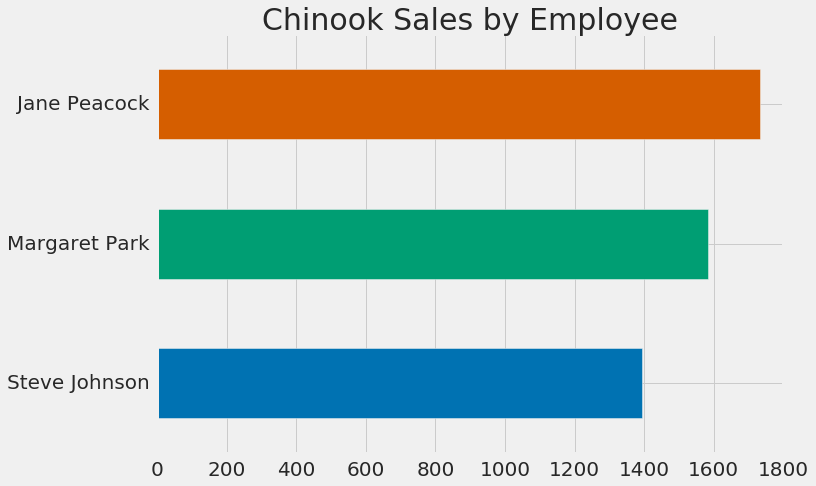

In [8]:
employee = run_query(query2)
employee.set_index("Name",drop=True,inplace=True)
employee["Sales Total"].plot.barh(figsize=(10,7), fontsize=20)
plt.ylabel('')
plt.title("Chinook Sales by Employee", fontsize=30)

## 4.- Analyzing Sales by Country.

Analyze each country's perfomance for total number of customers, total value of sales, average value of sales per customer and average order value.

In [9]:
query3 = """SELECT 
            c.country AS Country,
            COUNT(DISTINCT i.customer_id) AS "Total Customers",
            SUM(il.unit_price) AS "Total Sales in USD",
            SUM(il.unit_price)/COUNT(DISTINCT i.customer_id) AS "Average Value of Sales by Customer",
            SUM(il.unit_price)/COUNT(DISTINCT i.invoice_id) AS "Average Order Value"
                        
            FROM customer AS c
            INNER JOIN invoice AS i ON i.customer_id = c.customer_id
            INNER JOIN invoice_line AS il ON il.invoice_id = i.invoice_id
            GROUP BY 1
            ORDER BY 3 DESC;
            """
run_query(query3)

,Country,Total Customers,Total Sales in USD,Average Value of Sales by Customer,Average Order Value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Ireland,1,114.84,114.840000,8.833846


It seems that there's a majority of countries with only 1 customer. I should group these countries as "Other" to simplify analysis. In order to to this I have to create another `VIEW` and use a `CASE` statement.

In [10]:
command2 = """CREATE VIEW countries_others AS 
            SELECT
               CASE
                   WHEN (SELECT COUNT(*) FROM customer WHERE country = c.country) = 1 THEN "Other"
                   ELSE c.country
               END AS Country,
               c.customer_id,
               il.*
                 FROM invoice_line il
                 INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                 INNER JOIN customer c ON c.customer_id = i.customer_id
                 
"""

run_command(command2)

OperationalError: table countries_others already exists

In [11]:
query4 = """SELECT 
                Country,
                "Total Customers",
                "Total Sales in USD",
                "Average Value of Sales by Customer",
                "Average Order Value"
            FROM
            
            (SELECT 
            c.country AS Country,
            COUNT(DISTINCT c.customer_id) AS "Total Customers",
            SUM(c.unit_price) AS "Total Sales in USD",
            SUM(c.unit_price)/COUNT(DISTINCT c.customer_id) AS "Average Value of Sales by Customer",
            SUM(c.unit_price)/COUNT(DISTINCT c.invoice_id) AS "Average Order Value",
            CASE
                WHEN c.country = "Other" THEN 1
                ELSE 0
            END AS sorting
            FROM countries_others AS c
            GROUP BY 1
            ORDER BY sorting ASC, 1 ASC);
            """
run_query(query4)

,Country,Total Customers,Total Sales in USD,Average Value of Sales by Customer,Average Order Value
0,Brazil,5,427.68,85.536000,7.011148
1,Canada,8,535.59,66.948750,7.047237
2,Czech Republic,2,273.24,136.620000,9.108000
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,India,2,183.15,91.575000,8.721429
6,Portugal,2,185.13,92.565000,6.383793
7,USA,13,1040.49,80.037692,7.942672
8,United Kingdom,3,245.52,81.840000,8.768571
9,Other,15,1094.94,72.996000,7.448571


I needed to nest a sorted subquery inside the outer query to get "Other" moved to the last row.

## 5.- Visualizing Sales by Country.
I'll now save the queried country data into a pandas dataframe to analyze it. First I'll change the names of the countries because they're too long and will clutter the plots. At the same time I will use a colorblind friendly palette with the same color for each country. I will use individual plots and later group them in one figure.

I'll follow the teachings of Edward Tufte and maximize data ink ratio as much as I can.

In [12]:
country_analytics = run_query(query4)
country_analytics.replace(to_replace="United Kingdom", value="U.K.", inplace=True)
country_analytics.replace(to_replace="USA", value="U.S.A.", inplace=True)
country_analytics.replace(to_replace="Czech Republic", value="Czech R.", inplace=True)
country_analytics.set_index("Country",drop=True,inplace=True)

colorblind = [(0/255,107/255,164/255),(255/255,128/255,14/255),(171/255,171/255,171/255),
              (89/255,89/255,89/255),(95/255,158/255,209/255),(200/255,82/255,0/255),
              (137/255,137/255,137/255),(162/255,200/255,236/255),(255/255,188/255,121/255),
              (207/255,207/255,207/255)]

It's better to use different plot types, so I'll try with pie, bar and horizontal bar and see how they look.

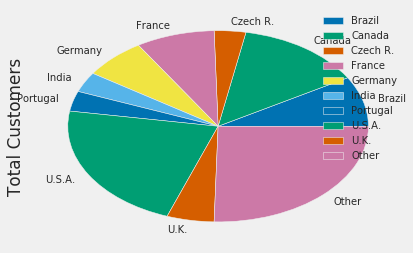

In [13]:
country_analytics.plot.pie(y="Total Customers")

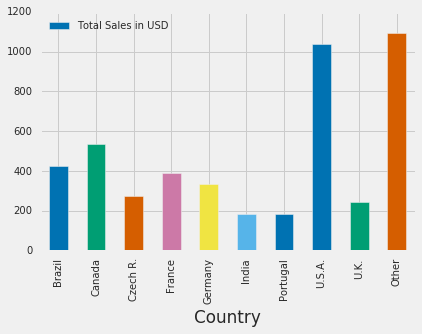

In [14]:
country_analytics.plot.bar(y="Total Sales in USD")

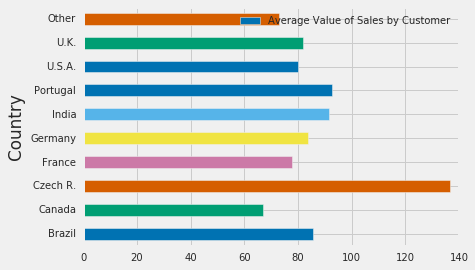

In [15]:
country_analytics.plot.barh(y="Average Value of Sales by Customer")

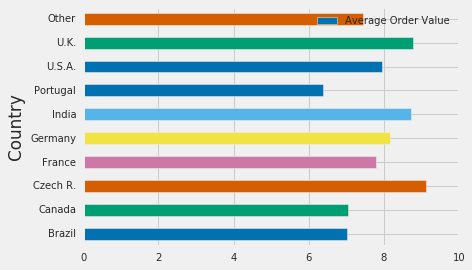

In [16]:
country_analytics.plot.barh(y="Average Order Value")

The plots have such terrible standard format. I will plot a single view including all 4 plots and change it's aesthetics.

(9.5, -0.5)

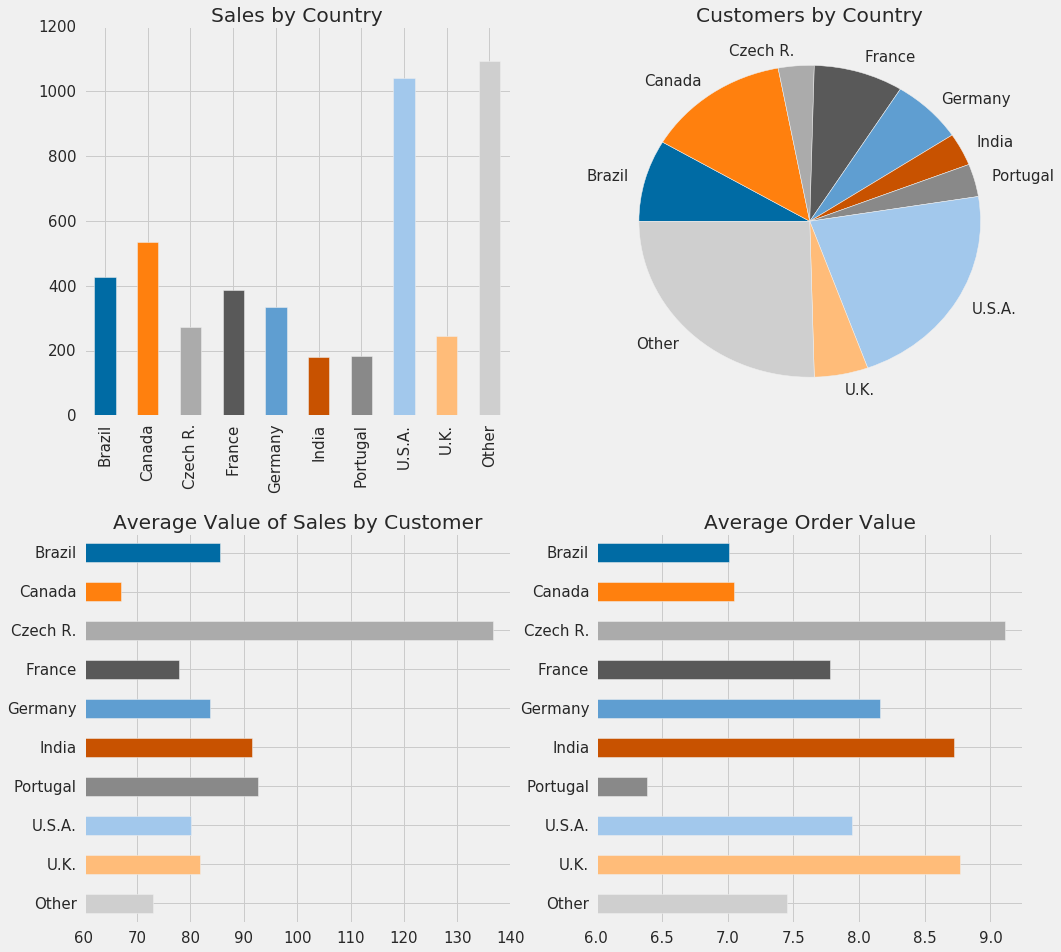

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.3, wspace=.2)

country_analytics.plot.bar(y="Total Sales in USD", legend=False,
                           color=colorblind, ax=ax1, 
                           title='Sales by Country', fontsize=15)
ax1.set_xlabel("")

country_analytics.plot.pie(y="Total Customers",legend=False, 
                           startangle=180, colors=colorblind, 
                           counterclock=False, ax=ax2,
                           title='Customers by Country', fontsize=15)
ax2.set_ylabel("")

country_analytics.plot.barh(y="Average Value of Sales by Customer", xlim=(60,140),
                            legend=False, color=colorblind, ax=ax3,
                            title='Average Value of Sales by Customer', fontsize=15)
ax3.set_ylabel("")
ax3.set_ylim(ax3.get_ylim()[::-1]) #This will reverse order of countries.
country_analytics.plot.barh(y="Average Order Value", xlim=(6,9.25),
                            legend=False, color=colorblind, ax=ax4,
                            title="Average Order Value", fontsize=15)
ax4.set_ylabel("")
ax4.set_ylim(ax4.get_ylim()[::-1]) #This will reverse order of countries.
#ax4.tick_params(labelleft="off")  #This would erase the names on the left.

Although my money is set in the Czech Republic, it would be a safe bet to let the marketing team to invest in Czech Republic, India and U.K. But this dataset is very small, I would need much more datapoints to accurately do a recomendation. It's very interesting that U.S.A. does not have niche customers like Czech Republic.


## 6.- Albums vs Individual Tracks.
Management wants to know if they should change their purchasing strategy to save money. I have to compare how many invoices where for whole albums vs individual tracks. After that, I'll need to calculate the following summary statistics: number of invoices, and percentage of invoices. 

In [18]:
command3 = """CREATE VIEW id_track_album AS
                SELECT
                 il.invoice_id AS invoice_id,
                 MIN(il.track_id) AS first_track_id,
                 t.album_id AS album_id
         
                 FROM invoice_line il
                 INNER JOIN track AS t ON t.track_id = il.track_id
                 GROUP BY 1;"""

run_command(command3)

OperationalError: table id_track_album already exists

In [19]:
run_query("""SELECT
                 il.invoice_id AS invoice_id,
                 MIN(il.track_id) AS first_track_id,
                 t.album_id AS album_id
         
                 FROM invoice_line il
                 INNER JOIN track AS t ON t.track_id = il.track_id
                 GROUP BY 1;""")

,invoice_id,first_track_id,album_id
0,1,1158,91
1,2,201,20
2,3,2516,203
3,4,748,58
4,5,1986,163
5,6,30,5
6,7,42,6
7,8,81,9
8,9,196,20
9,10,2663,215


In [20]:
query6 = """
                SELECT il.track_id FROM invoice_line AS il
                WHERE il.invoice_id = 1
                EXCEPT
                
                SELECT t.track_id FROM track AS t
                WHERE album_id = 91
            
         """

run_query(query6)

,track_id


In [21]:
query7 = """
                SELECT t.track_id FROM track AS t
                WHERE album_id = 91    
                    
                EXCEPT
                
                SELECT il.track_id FROM invoice_line AS il
                WHERE il.invoice_id = 1

            """
run_query(query7)

,track_id


In [22]:
query8 = """
                SELECT il.track_id FROM invoice_line AS il
                WHERE il.invoice_id = 2
                EXCEPT
                
                SELECT t.track_id FROM track AS t
                WHERE album_id = 20
            
         """

run_query(query8)

,track_id
0,392
1,482
2,819
3,1119
4,1641
5,2324
6,2651
7,2701
8,3476


In [23]:
query9 = """
                SELECT t.track_id FROM track AS t
                WHERE album_id = 20    
                    
                EXCEPT
                
                SELECT il.track_id FROM invoice_line AS il
                WHERE il.invoice_id = 2

            """
run_query(query9)

,track_id
0,194
1,195
2,196
3,197
4,198
5,199
6,200
7,202
8,203
9,204


In [24]:
query10 = """SELECT 


            COUNT(ita.invoice_id) AS Invoices,
            1.0*COUNT(ita.invoice_id)/(SELECT COUNT(*) FROM invoice) AS "%",

            CASE
                    WHEN (
                            SELECT il.track_id FROM invoice_line AS il
                            WHERE il.invoice_id = ita.invoice_id
                            
                            EXCEPT
                
                            SELECT t.track_id FROM track AS t
                            WHERE album_id = (SELECT album_id FROM track WHERE track_id = ita.first_track_id)
                          ) IS NULL
                          
                    AND
                         (
                            SELECT t.track_id FROM track AS t
                            WHERE album_id = (SELECT album_id FROM track WHERE track_id = ita.first_track_id)    
                    
                            EXCEPT
                
                            SELECT il.track_id FROM invoice_line AS il
                            WHERE il.invoice_id = ita.invoice_id
                          ) IS NULL
                          
                      THEN "Yes"
                      ELSE "No"
            END AS "Complete Purchase"
            FROM id_track_album AS ita
            GROUP BY 3
            ORDER BY 1;
            

"""
run_query(query10)

,Invoices,%,Complete Purchase
0,114,0.185668,Yes
1,500,0.814332,No


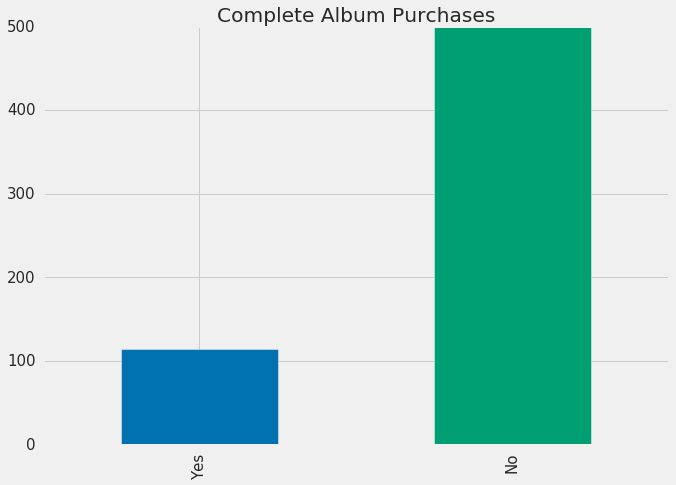

In [25]:
album_vs_track = run_query(query10)
album_vs_track.set_index("Complete Purchase",drop=True,inplace=True)
album_vs_track.plot.bar(y="Invoices",legend=False,
                        figsize=(10,7),fontsize=15,
                       title="Complete Album Purchases")
plt.xlabel("")

Management is considering to purchase only the most popular tracks from each album from record companies and allow customers to purchase this limited number of tracks. According to the plot above, almost 20% off all invoices are for complete albums, which means we are in danger of losing all that revenue. I would recommend against management's consideration.

## 7.- Next Steps.
* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?

To be continued...